In [178]:
from helpers import laplace, divergence, gradient, ImageFitting
from siren import Siren

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import os

import pennylane as qml
from pennylane import numpy as np

from PIL import Image
from torchvision.transforms import Resize, Compose, ToTensor, Normalize
import skimage
import matplotlib.pyplot as plt

import time

In [179]:
sidelength=14

In [180]:
cameraman = ImageFitting(sidelength)
dataloader = DataLoader(cameraman, batch_size=1, pin_memory=True, num_workers=0)

img_siren = Siren(in_features=2, out_features=1, hidden_features=64,
                  hidden_layers=3, outermost_linear=True)

In [181]:
dev = qml.device("default.qubit", wires=2, shots=None)

@qml.batch_input(argnum=1)
@qml.qnode(dev, diff_method="parameter-shift", interface="torch")
def circuit(inputs, weights):
    qml.RY(weights[0][0], wires=0)
    qml.AngleEmbedding(inputs, wires=range(2), rotation="Y")
    qml.RY(weights[1][1], wires=1)
    return qml.expval(qml.PauliZ(1))

x = torch.rand(size=(10, 2))
w = torch.rand(size=(4, 5,))

circuit(x, w)

tensor([0.3182, 0.8103, 0.5481, 0.7583, 0.4983, 0.7892, 0.2846, 0.8938, 0.2169,
        0.4320], dtype=torch.float64)

In [182]:
print(qml.draw(circuit, expansion_strategy="device")(x, w))

0: ──RY(0.68)─╭AngleEmbedding(M0)───────────┤     
1: ───────────╰AngleEmbedding(M0)──RY(0.36)─┤  <Z>

0: ──RY(0.68)─╭AngleEmbedding(M1)───────────┤     
1: ───────────╰AngleEmbedding(M1)──RY(0.36)─┤  <Z>

0: ──RY(0.68)─╭AngleEmbedding(M2)───────────┤     
1: ───────────╰AngleEmbedding(M2)──RY(0.36)─┤  <Z>

0: ──RY(0.68)─╭AngleEmbedding(M3)───────────┤     
1: ───────────╰AngleEmbedding(M3)──RY(0.36)─┤  <Z>

0: ──RY(0.68)─╭AngleEmbedding(M4)───────────┤     
1: ───────────╰AngleEmbedding(M4)──RY(0.36)─┤  <Z>

0: ──RY(0.68)─╭AngleEmbedding(M5)───────────┤     
1: ───────────╰AngleEmbedding(M5)──RY(0.36)─┤  <Z>

0: ──RY(0.68)─╭AngleEmbedding(M6)───────────┤     
1: ───────────╰AngleEmbedding(M6)──RY(0.36)─┤  <Z>

0: ──RY(0.68)─╭AngleEmbedding(M7)───────────┤     
1: ───────────╰AngleEmbedding(M7)──RY(0.36)─┤  <Z>

0: ──RY(0.68)─╭AngleEmbedding(M8)───────────┤     
1: ───────────╰AngleEmbedding(M8)──RY(0.36)─┤  <Z>

0: ──RY(0.68)─╭AngleEmbedding(M9)───────────┤     
1: ───────────╰AngleEm

In [183]:
w

tensor([[0.6781, 0.8099, 0.7632, 0.2815, 0.9617],
        [0.8182, 0.3574, 0.8380, 0.3212, 0.9063],
        [0.4000, 0.1503, 0.9300, 0.2509, 0.6349],
        [0.9891, 0.1252, 0.3985, 0.9490, 0.2964]])

Step 0, Total loss 0.293302


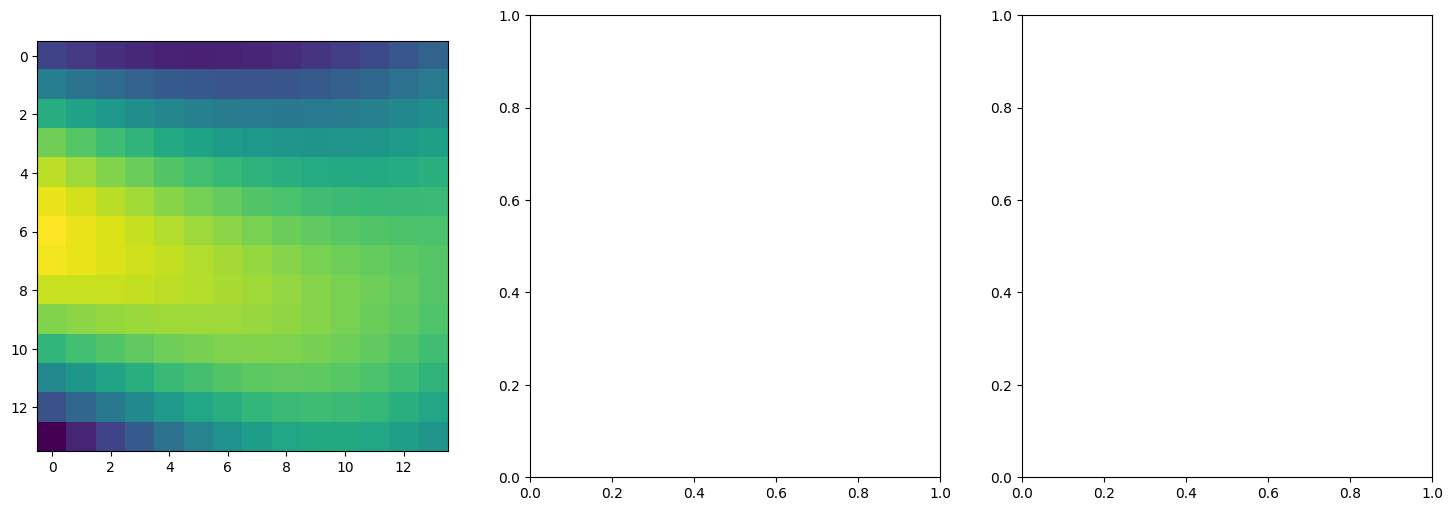

KeyboardInterrupt: 

In [184]:
total_steps = 500 # Since the whole image is our dataset, this just means 500 gradient descent steps.
steps_til_summary = 1

n_qubits = 3
n_gates_per_layer = 3
n_layer = 4

dev = qml.device("default.qubit", wires=n_qubits, shots=None)

@qml.batch_input(argnum=0)
@qml.qnode(dev, diff_method="parameter-shift", interface="torch")
def circuit(coords, params):
    # qml.RY(coords[0], wires=0)
    # qml.RY(coords[1], wires=1)
    qml.AngleEmbedding(coords, wires=range(params.shape[1]-1), rotation="Y")

    qml.Barrier(wires=range(n_qubits))

    for l, l_params in enumerate(params):
        for q, l_q_params in enumerate(l_params):
            qml.RX(l_q_params[0], wires=q)
            qml.RY(l_q_params[1], wires=q)

            qml.CRX(l_q_params[2], wires=[q, (q+1)%params.shape[1]])

    return qml.expval(qml.PauliZ(2))


# params = np.random.uniform(size=(sidelength,sidelength))
params = torch.rand(size=(n_layer,n_qubits,n_gates_per_layer), requires_grad=True) # nLayers, nQubits, nGatesPerLayer

optim = torch.optim.Adam(lr=1e-4, params=[params])

model_input, ground_truth = next(iter(dataloader))
model_input, ground_truth = model_input, ground_truth

for step in range(total_steps):
    # model_output, coords = img_siren(model_input)

    model_output = circuit(model_input[0], params)
    model_output = model_output.reshape((1, model_output.shape[0], 1))
    coords = model_input

    loss = ((model_output - ground_truth)**2).mean()

    if not step % steps_til_summary:
        print("Step %d, Total loss %0.6f" % (step, loss))
        # img_grad = gradient(model_output, coords)
        # img_laplacian = laplace(model_output, coords)

        fig, axes = plt.subplots(1,3, figsize=(18,6))
        axes[0].imshow(model_output.cpu().view(sidelength,sidelength).detach().numpy())
        # axes[1].imshow(img_grad.norm(dim=-1).cpu().view(sidelength,sidelength).detach().numpy())
        # axes[2].imshow(img_laplacian.cpu().view(sidelength,sidelength).detach().numpy())
        plt.show()

    optim.zero_grad()
    loss.backward()
    optim.step()